# Analisi funzionamento cross project

In [1]:
import warnings
import pandas as pd
import os

warnings.filterwarnings("ignore")


datasetName='FlakeFlagger_Pulito'
dataset = pd.read_csv(os.path.join('..','..','Dataset','{}.csv'.format(datasetName)))
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9484 entries, 0 to 9483
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   nameProject               9484 non-null   object 
 1   testCase                  9484 non-null   object 
 2   tloc                      9484 non-null   int64  
 3   tmcCabe                   9484 non-null   int64  
 4   assertionDensity          9484 non-null   float64
 5   assertionRoulette         9484 non-null   int64  
 6   mysteryGuest              9484 non-null   int64  
 7   eagerTest                 9484 non-null   int64  
 8   sensitiveEquality         9484 non-null   int64  
 9   resourceOptimism          9484 non-null   int64  
 10  conditionalTestLogic      9484 non-null   int64  
 11  fireAndForget             9484 non-null   int64  
 12  testRunWar                9484 non-null   int64  
 13  loc                       9484 non-null   int64  
 14  lcom2   

Seleziono 3 repository in modo casuale su cui eseguire l'analisi:

In [2]:
import random

random.seed(42)
list_repository=dataset['nameProject'].unique()
repository1=random.choice(list_repository)
repository2=random.choice(list_repository)
repository3=random.choice(list_repository)

print("Repository 1: {}".format(repository1))
print("Repository 2: {}".format(repository2))
print("Repository 3: {}".format(repository3))

Repository 1: hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb
Repository 2: activiti_b11f757a
Repository 3: hector_29e88d0b988d9e5c8dc3b529414a270805ce0d7c


## 1. CrossProject - Standard

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score


def eval_and_log_metrics(prefix,  y_true, y_predict):
    acc=accuracy_score(y_true,y_predict)
    pr=precision_score(y_true,y_predict)
    rec=recall_score(y_true,y_predict)
    f1=f1_score(y_true,y_predict)

    print("    |--- {}_ACC".format(prefix),acc)
    print("    |--- {}_PR".format(prefix),pr)
    print("    |--- {}_REC".format(prefix),rec)
    print("    |--- {}_F1".format(prefix),f1)

    return acc,pr,rec,f1


def val_and_log_metrics(y_true, y_predict,print=True):
    acc = accuracy_score(y_true, y_predict)
    pr = precision_score(y_true, y_predict)
    rec = recall_score(y_true, y_predict)
    f1 = f1_score(y_true, y_predict)
    auc = roc_auc_score(y_true, y_predict)
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    fpr, tpr, _ = roc_curve(y_true,  y_predict)
    
    if print:
        print("    |--- TEST_ACC",acc)
        print("    |--- TEST_PR",pr)
        print("    |--- TEST_REC",rec)
        print("    |--- TEST_F1",f1)
        print("    |--- TEST_AUC",auc)

    return acc, pr, rec, f1, tn, fp, fn, tp

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import copy
import mlflow
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd


def informationGain_epplsilon_feature(X,y):
    eppsilon_feature=[]

    randomForest=RandomForestClassifier(n_estimators=200,random_state=0,n_jobs=1)
    columns_name=X.columns  #Nome Features
    randomForest.fit(X=X,y=y)
    importanceFeatures=randomForest.feature_importances_
    indices = np.argsort(importanceFeatures)[::-1] #Ordino gli indici in maniera decrescente


    for f in range(X.shape[1]):
        if importanceFeatures[indices[f]] < 0.02:
            eppsilon_feature.append(X.columns[indices[f]])

    return eppsilon_feature


def multicollinearity_eppsilon_feature(X):
    eppsilon_features=[]

    eliminato = True
    while eliminato:
        max = 0

        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  # Calcolo il vif
        vif["features"] = X.columns

        for vif_value, feature in zip(vif["VIF Factor"], vif["features"]):
            if vif_value >= 5:
                if vif_value > max:
                    max = vif_value
                    feature_da_rimuovere = feature

        if max > 0:
            eliminato = True
            X = X.drop([feature_da_rimuovere], axis=1)
            eppsilon_features.append(feature_da_rimuovere)
        else:
            eliminato = False

    return eppsilon_features



class FeatureSelection(BaseEstimator, TransformerMixin):


    def fit(self, X, y=None):
        self.eppsilon_features=[]
        X_copy=copy.copy(X)
        if isinstance(X_copy, np.ndarray):
            X_copy = pd.DataFrame(X_copy)

        #Multicollinearity
        self.eppsilon_features=self.eppsilon_features+multicollinearity_eppsilon_feature(X_copy)
        X_copy.drop(self.eppsilon_features,axis=1)
        #Information Gain
        self.eppsilon_features=self.eppsilon_features+informationGain_epplsilon_feature(X_copy,y)
        mlflow.log_param("Eppsilon_features",len(self.eppsilon_features))
        return self



    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X=X.drop(self.eppsilon_features,axis=1)
        return X

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X,y)
        X=self.transform(X)
        return X

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



list_target=[repository1, repository2, repository3]

tmp={
    'repository': [],
    'X_source_train': [],
    'y_source_train': [],
    'X_source_test': [],
    'y_source_test': [],
    'X_target': [],
    'y_target': [],
    'clf': [],
}

for target in list_target:
    print('Repository: {}'.format(target))
    
    tmp['repository'].append(target)
    target_set=dataset.loc[dataset['nameProject']==target]
    source_set=dataset.loc[dataset['nameProject']!=target]

    X_target=target_set.drop(['nameProject','testCase','isFlaky'], axis=1)
    y_target=target_set['isFlaky']
    X_source=source_set.drop(['nameProject','testCase','isFlaky'], axis=1)
    y_source=source_set['isFlaky']
    
    columns=X_source.columns

    X_source_train, X_source_test, y_source_train, y_source_test= train_test_split(X_source, y_source,stratify=y_source, test_size=0.20,random_state=42)
    
    tmp['X_source_train'].append(X_source_train)
    tmp['y_source_train'].append(y_source_train)
    tmp['X_source_test'].append(X_source_test)
    tmp['y_source_test'].append(y_source_test)
    tmp['X_target'].append(X_target)
    tmp['y_target'].append(y_target)
    
    pipeline = Pipeline(steps = [('scaler',MinMaxScaler()),
                                 ("model", RandomForestClassifier(criterion='gini',
                                                                  n_estimators=150,
                                                                  class_weight='balanced', random_state=42))])

    pipeline.fit(X_source_train,y_source_train)
    y_predict=pipeline.predict(X_source_train)
    eval_and_log_metrics('Train',y_source_train,y_predict)
    print('     Performance Test')
    y_predict=pipeline.predict(X_source_test)
    val_and_log_metrics(y_source_test,y_predict)
    print('     Performance Target')
    y_predict=pipeline.predict(X_target)
    val_and_log_metrics(y_target,y_predict)
    print('')
    
    tmp['clf'].append(pipeline.get_params('steps')['model'])
    

Repository: hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb
    |--- Train_ACC 1.0
    |--- Train_PR 1.0
    |--- Train_REC 1.0
    |--- Train_F1 1.0
     Performance Test
    |--- TEST_ACC 0.9780821917808219
    |--- TEST_PR 0.8656716417910447
    |--- TEST_REC 0.651685393258427
    |--- TEST_F1 0.7435897435897435
    |--- TEST_AUC 0.8232505307305961
     Performance Target
    |--- TEST_ACC 0.6777777777777778
    |--- TEST_PR 0.4
    |--- TEST_REC 0.03508771929824561
    |--- TEST_F1 0.06451612903225806
    |--- TEST_AUC 0.5053487376979033

Repository: activiti_b11f757a
    |--- Train_ACC 1.0
    |--- Train_PR 1.0
    |--- Train_REC 1.0
    |--- Train_F1 1.0
     Performance Test
    |--- TEST_ACC 0.978513356562137
    |--- TEST_PR 0.9285714285714286
    |--- TEST_REC 0.7155963302752294
    |--- TEST_F1 0.8082901554404146
    |--- TEST_AUC 0.8559382767309192
     Performance Target
    |--- TEST_ACC 0.9816933638443935
    |--- TEST_PR 0.0
    |--- TEST_REC 0.0
    |--- TEST_F1 0.0
   

In [6]:
from IPython.display import display
import numpy as np


def print_distribution(X_source_train, X_source_test, X_target, columns):
    
    data={
        'column':[],
        
        'Mean_S_TR':[],
        'STD_S_TR': [],
        'Mean_S_T':[],
        'STD_S_T': [],
        'Mean_T':[],
        'STD_T': [],
        
        'Min_S_TR':[],
        'Max_S_TR': [],
        'Min_S_T':[],
        'Max_S_T': [],
        'Min_T':[],
        'Max_T': [],
    }
    
    for col in columns:
        data['column'].append(col)
        
        data['Mean_S_TR'].append(X_source_train[col].mean())
        data['STD_S_TR'].append(X_source_train[col].std())
        data['Mean_S_T'].append(X_source_test[col].mean())
        data['STD_S_T'].append(X_source_test[col].std())
        data['Mean_T'].append(X_target[col].mean())
        data['STD_T'].append(X_target[col].std())
        
        data['Min_S_TR'].append(X_source_train[col].min())
        data['Max_S_TR'].append(X_source_train[col].max())
        data['Min_S_T'].append(X_source_test[col].min())
        data['Max_S_T'].append(X_source_test[col].max())
        data['Min_T'].append(X_target[col].min())
        data['Max_T'].append(X_target[col].max())
    
    df=pd.DataFrame(data)
    display(df)


def print_featureImportances(clf,columns):

    importanceFeatures=clf.feature_importances_
    indices = np.argsort(importanceFeatures)[::-1]
    for i in indices:
        print('{} : {}'.format(columns[i], importanceFeatures[i]))
    
    

In [7]:
for i in range(0,len(tmp['repository'])):
    print(tmp['repository'][i])
    print_distribution(tmp['X_source_train'][i], 
                       tmp['X_source_test'][i], 
                       tmp['X_target'][i], 
                       columns)
    print('\n Feature Importances')
    print_featureImportances(tmp['clf'][i],columns)
    print('\n')
    

hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb


,column,Mean_S_TR,STD_S_TR,Mean_S_T,STD_S_T,Mean_T,STD_T,Min_S_TR,Max_S_TR,Min_S_T,Max_S_T,Min_T,Max_T
0,tloc,10.819427,10.965291,10.602740,11.577139,20.091667,17.753024,2.0,194.000000,2.0,187.000000,2.0,109.000000
1,tmcCabe,2.175366,0.968080,2.190137,0.940390,2.758333,1.073841,1.0,9.000000,1.0,6.000000,1.0,7.000000
2,assertionDensity,0.154304,0.224010,0.141676,0.200503,0.097307,0.145783,0.0,1.788732,0.0,1.500000,0.0,0.842105
3,assertionRoulette,1.571859,3.073750,1.431781,2.623460,2.444444,4.090511,0.0,52.000000,0.0,24.000000,0.0,40.000000
4,mysteryGuest,0.250582,1.389222,0.217534,1.238243,0.211111,1.146577,0.0,22.000000,0.0,20.000000,0.0,13.000000
5,eagerTest,1.672558,2.701446,1.567671,2.389888,2.502778,3.191212,0.0,42.000000,0.0,23.000000,0.0,14.000000
6,sensitiveEquality,0.029045,0.232895,0.021918,0.157285,0.025000,0.216164,0.0,6.000000,0.0,2.000000,0.0,2.000000
7,resourceOptimism,0.020962,0.183520,0.020274,0.207123,0.000000,0.000000,0.0,2.000000,0.0,5.000000,0.0,0.000000
8,conditionalTestLogic,0.704206,1.596978,0.711781,1.729263,2.119444,3.594279,0.0,37.000000,0.0,42.000000,0.0,23.000000
9,fireAndForget,0.011508,0.142902,0.009863,0.104248,0.027778,0.180700,0.0,5.000000,0.0,2.000000,0.0,2.000000



 Feature Importances
tloc : 0.09311358167634919
halsteadVocabulary : 0.08306445664456397
halsteadVolume : 0.08003649622329453
wmc : 0.07850923789474323
loc : 0.07616375675220743
halsteadLength : 0.07607171957369682
mpc : 0.06523848302866664
lcom2 : 0.06099855964315879
cbo : 0.057040656333604924
mysteryGuest : 0.050557073090011326
rfc : 0.0499092178004732
assertionDensity : 0.04738513800134234
eagerTest : 0.03926984918760636
assertionRoulette : 0.03426416072543857
tmcCabe : 0.032909592384881406
conditionalTestLogic : 0.02764956785233591
lcom5 : 0.02402269064785945
fireAndForget : 0.00590906239720777
spaghettiCode : 0.005474199156435799
complexClass : 0.0042157133255936495
resourceOptimism : 0.0023417209774260987
sensitiveEquality : 0.0023213104231725296
functionalDecomposition : 0.0020007124959912958
classDataShouldBePrivate : 0.0015330437639387638
testRunWar : 0.0
godClass : 0.0


activiti_b11f757a


,column,Mean_S_TR,STD_S_TR,Mean_S_T,STD_S_T,Mean_T,STD_T,Min_S_TR,Max_S_TR,Min_S_T,Max_S_T,Min_T,Max_T
0,tloc,10.794280,11.370814,10.414053,10.184406,15.183066,14.369319,2.0,194.000000,2.0,120.000000,3.000000,136.000000
1,tmcCabe,2.250871,0.985630,2.217770,0.965210,1.767735,0.762712,1.0,9.000000,1.0,8.000000,1.000000,6.000000
2,assertionDensity,0.146126,0.220993,0.140301,0.214346,0.196495,0.188024,0.0,1.788732,0.0,1.772727,0.000000,0.863636
3,assertionRoulette,1.448171,2.827233,1.363531,2.330161,3.024027,4.951598,0.0,46.000000,0.0,27.000000,0.000000,52.000000
4,mysteryGuest,0.260308,1.410114,0.264808,1.392110,0.060641,0.580107,0.0,22.000000,0.0,19.000000,0.000000,11.000000
5,eagerTest,1.670877,2.597283,1.654472,2.916762,1.844394,2.723374,0.0,42.000000,0.0,42.000000,0.000000,18.000000
6,sensitiveEquality,0.030633,0.239347,0.028455,0.189199,0.001144,0.033826,0.0,6.000000,0.0,2.000000,0.000000,1.000000
7,resourceOptimism,0.022213,0.193401,0.021487,0.196135,0.000000,0.000000,0.0,5.000000,0.0,2.000000,0.000000,0.000000
8,conditionalTestLogic,0.791812,1.830380,0.704413,1.511633,0.612128,1.644008,0.0,42.000000,0.0,17.000000,0.000000,21.000000
9,fireAndForget,0.013357,0.149910,0.011034,0.120019,0.001144,0.033826,0.0,5.000000,0.0,2.000000,0.000000,1.000000



 Feature Importances
tloc : 0.08961268151446206
wmc : 0.08656745455675076
loc : 0.08542460228126551
halsteadVolume : 0.07787527086301181
lcom2 : 0.0765350230727314
halsteadVocabulary : 0.07309734919286012
cbo : 0.06918585809899326
halsteadLength : 0.06696481281640637
mpc : 0.05936710583839135
rfc : 0.051706305734729924
assertionDensity : 0.04564519137476185
mysteryGuest : 0.03994052674832842
assertionRoulette : 0.035445821648995436
lcom5 : 0.032616537706298424
tmcCabe : 0.03259758095258692
eagerTest : 0.03070609407492443
conditionalTestLogic : 0.027245056372045648
fireAndForget : 0.006153589222230839
functionalDecomposition : 0.003429709494296192
spaghettiCode : 0.002276032381768186
resourceOptimism : 0.0021863134468109095
complexClass : 0.0018659502675040748
sensitiveEquality : 0.0018030218551556435
classDataShouldBePrivate : 0.0017521104846905647
testRunWar : 0.0
godClass : 0.0


hector_29e88d0b988d9e5c8dc3b529414a270805ce0d7c


,column,Mean_S_TR,STD_S_TR,Mean_S_T,STD_S_T,Mean_T,STD_T,Min_S_TR,Max_S_TR,Min_S_T,Max_S_T,Min_T,Max_T
0,tloc,11.101082,11.593512,11.078484,11.336196,13.672131,11.994105,2.0,194.000000,2.0,136.000000,2.000000,57.000000
1,tmcCabe,2.201095,0.971767,2.219434,0.958769,1.860656,1.208206,1.0,8.000000,1.0,9.000000,1.000000,5.000000
2,assertionDensity,0.150169,0.218041,0.149381,0.218713,0.126621,0.152860,0.0,1.772727,0.0,1.788732,0.000000,0.666667
3,assertionRoulette,1.553478,2.948291,1.641751,3.410534,2.106557,2.744814,0.0,52.000000,0.0,44.000000,0.000000,12.000000
4,mysteryGuest,0.257044,1.383771,0.201281,1.267003,0.000000,0.000000,0.0,22.000000,0.0,21.000000,0.000000,0.000000
5,eagerTest,1.675124,2.664727,1.725040,2.727804,1.590164,2.023638,0.0,42.000000,0.0,42.000000,0.000000,10.000000
6,sensitiveEquality,0.024970,0.191405,0.038975,0.311937,0.008197,0.090536,0.0,6.000000,0.0,6.000000,0.000000,1.000000
7,resourceOptimism,0.020697,0.182644,0.018687,0.199286,0.000000,0.000000,0.0,2.000000,0.0,5.000000,0.000000,0.000000
8,conditionalTestLogic,0.745493,1.648657,0.810464,2.163918,0.827869,1.497616,0.0,33.000000,0.0,42.000000,0.000000,8.000000
9,fireAndForget,0.011350,0.128703,0.014415,0.173899,0.000000,0.000000,0.0,5.000000,0.0,5.000000,0.000000,0.000000



 Feature Importances
wmc : 0.09173186272163572
halsteadVolume : 0.0852485326807959
loc : 0.08044733332867063
halsteadLength : 0.07232762330561397
lcom2 : 0.07176253214485713
halsteadVocabulary : 0.07109473097818099
tloc : 0.06988546959502216
cbo : 0.06816064759657839
mpc : 0.06285890627807328
rfc : 0.0544954015921205
mysteryGuest : 0.047493043873119006
tmcCabe : 0.043477320741322587
assertionDensity : 0.04067478423693871
assertionRoulette : 0.03230283493286688
eagerTest : 0.031613576734116515
lcom5 : 0.030134236222951364
conditionalTestLogic : 0.025409294026895006
fireAndForget : 0.006269245056863044
functionalDecomposition : 0.004486410576393735
complexClass : 0.0027527587571000004
spaghettiCode : 0.0025704056795460644
resourceOptimism : 0.0021300955018590784
classDataShouldBePrivate : 0.0014117270731340663
sensitiveEquality : 0.0012612263653452146
testRunWar : 0.0
godClass : 0.0




## 2. CrossProject - BurakFilter

In [8]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))

def classic_burakFilter(Xsource,ysource,Xtarget,ytarget,k):
    
    knn=KNeighborsClassifier()
    knn.fit(Xsource,ysource)

    Xdata=[]
    ydata=[]
    
    TF_countTF=0
    TF_countTNF=0
    TNF_countTF=0
    TNF_countTNF=0

    for instance,l in zip(Xtarget,ytarget):
        neighbors_index=knn.kneighbors(instance.reshape(1,-1), k, return_distance=False)
        for neighbor_index in neighbors_index[0]:
            
            if l==0:
                if ysource[neighbor_index]==0: TNF_countTNF=TNF_countTNF+1
                else: TNF_countTF=TNF_countTF+1
            else:
                if ysource[neighbor_index]==0: TF_countTNF=TF_countTNF+1
                else: TF_countTF=TF_countTF+1
                    
            if not list(Xsource[neighbor_index]) in Xdata:
                Xdata.append(list(Xsource[neighbor_index]))
                ydata.append(ysource[neighbor_index])
                
    
    print("Per le istanze non flaky sono stati selezionati: {} TF e {} TNF".format(TNF_countTF,TNF_countTNF))
    print("Per le istanze flaky sono stati selezionati: {} TF e {} TNF\n".format(TF_countTF,TF_countTNF))
    print("Con il filtro di burak il source set è stato ridotto passado da {} TF, {} TNF a {} TF, {} TNF\n".format(
        np.count_nonzero(ysource),
        ysource.size - np.count_nonzero(ysource),
        np.count_nonzero(np.asarray(ydata)),
        np.asarray(ydata).size - np.count_nonzero(np.asarray(ydata))
    ))

    return np.asanyarray(Xdata), np.asarray(ydata)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



list_target=[repository1, repository2, repository3]

tmp={
    'repository': [],
    'X_source_train': [],
    'y_source_train': [],
    'X_source_test': [],
    'y_source_test': [],
    'X_target': [],
    'y_target': [],
    'clf': [],
}

for target in list_target:
    print('Repository: {}'.format(target))
    
    tmp['repository'].append(target)
    target_set=dataset.loc[dataset['nameProject']==target]
    source_set=dataset.loc[dataset['nameProject']!=target]

    X_target=target_set.drop(['nameProject','testCase','isFlaky'], axis=1)
    y_target=target_set['isFlaky']
    X_source=source_set.drop(['nameProject','testCase','isFlaky'], axis=1)
    y_source=source_set['isFlaky']
    columns=X_source.columns
    
    X_source,y_source=classic_burakFilter(X_source.to_numpy(),y_source.to_numpy(),X_target.to_numpy(),y_target.to_numpy(),10)
    X_source_train, X_source_test, y_source_train, y_source_test= train_test_split(X_source, y_source,stratify=y_source, test_size=0.20,random_state=42)
    
    tmp['X_source_train'].append(pd.DataFrame(X_source_train,columns=columns))
    tmp['y_source_train'].append(y_source_train)
    tmp['X_source_test'].append(pd.DataFrame(X_source_test,columns=columns))
    tmp['y_source_test'].append(y_source_test)
    tmp['X_target'].append(pd.DataFrame(X_target,columns=columns))
    tmp['y_target'].append(y_target)
    
    pipeline = Pipeline(steps = [('scaler',MinMaxScaler()),
                                 ("model", RandomForestClassifier(class_weight='balanced', random_state=42))]).set_output(transform = "pandas")

    pipeline.fit(X_source_train,y_source_train)
    y_predict=pipeline.predict(X_source_train)
    eval_and_log_metrics('Train',y_source_train,y_predict)
    print('     Performance Test')
    y_predict=pipeline.predict(X_source_test)
    val_and_log_metrics(y_source_test,y_predict)
    print('     Performance Target')
    y_predict=pipeline.predict(X_target)
    val_and_log_metrics(y_target,y_predict)
    print('')
    
    tmp['clf'].append(pipeline.get_params('steps')['model'])
    

Repository: hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb
Per le istanze non flaky sono stati selezionati: 609 TF e 1851 TNF
Per le istanze flaky sono stati selezionati: 85 TF e 1055 TNF

Con il filtro di burak il source set è stato ridotto passado da 445 TF, 8679 TNF a 48 TF, 555 TNF

    |--- Train_ACC 1.0
    |--- Train_PR 1.0
    |--- Train_REC 1.0
    |--- Train_F1 1.0
     Performance Test
    |--- TEST_ACC 0.9752066115702479
    |--- TEST_PR 1.0
    |--- TEST_REC 0.7
    |--- TEST_F1 0.8235294117647058
    |--- TEST_AUC 0.85
     Performance Target
    |--- TEST_ACC 0.5861111111111111
    |--- TEST_PR 0.14285714285714285
    |--- TEST_REC 0.06140350877192982
    |--- TEST_F1 0.08588957055214724
    |--- TEST_AUC 0.4453359007274283

Repository: activiti_b11f757a
Per le istanze non flaky sono stati selezionati: 254 TF e 8326 TNF
Per le istanze flaky sono stati selezionati: 0 TF e 160 TNF

Con il filtro di burak il source set è stato ridotto passado da 543 TF, 8067 TNF a 30 TF, 56

In [10]:
for i in range(0,len(tmp['repository'])):
    print(tmp['repository'][i])
    print_distribution(tmp['X_source_train'][i], 
                       tmp['X_source_test'][i], 
                       tmp['X_target'][i], 
                       columns)
    print('\n Feature Importances')
    print_featureImportances(tmp['clf'][i],columns)
    print('\n')


hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb


,column,Mean_S_TR,STD_S_TR,Mean_S_T,STD_S_T,Mean_T,STD_T,Min_S_TR,Max_S_TR,Min_S_T,Max_S_T,Min_T,Max_T
0,tloc,11.960581,12.074634,10.628099,7.417471,20.091667,17.753024,2.0,131.000000,3.0,43.000000,2.0,109.000000
1,tmcCabe,2.161826,0.890441,2.132231,0.884516,2.758333,1.073841,1.0,6.000000,1.0,5.000000,1.0,7.000000
2,assertionDensity,0.207379,0.271881,0.192790,0.290769,0.097307,0.145783,0.0,1.590909,0.0,1.772727,0.0,0.842105
3,assertionRoulette,1.931535,3.862163,1.537190,1.875461,2.444444,4.090511,0.0,44.000000,0.0,12.000000,0.0,40.000000
4,mysteryGuest,0.587137,2.120507,0.396694,1.599371,0.211111,1.146577,0.0,17.000000,0.0,10.000000,0.0,13.000000
5,eagerTest,2.020747,3.541202,2.157025,5.600608,2.502778,3.191212,0.0,42.000000,0.0,42.000000,0.0,14.000000
6,sensitiveEquality,0.026971,0.297772,0.057851,0.267629,0.025000,0.216164,0.0,6.000000,0.0,2.000000,0.0,2.000000
7,resourceOptimism,0.029046,0.211879,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.0,0.000000,0.0,0.000000
8,conditionalTestLogic,0.560166,1.351641,0.429752,1.223563,2.119444,3.594279,0.0,11.000000,0.0,8.000000,0.0,23.000000
9,fireAndForget,0.016598,0.157073,0.024793,0.272727,0.027778,0.180700,0.0,2.000000,0.0,3.000000,0.0,2.000000



 Feature Importances
mysteryGuest : 0.1305759456579947
halsteadVocabulary : 0.11473569187060258
mpc : 0.0904383616493648
halsteadVolume : 0.08255491054624384
wmc : 0.08207954355762463
loc : 0.06920614862940681
rfc : 0.06417688183569857
halsteadLength : 0.05951110269656888
cbo : 0.04979777725126897
lcom2 : 0.04477036937593702
assertionRoulette : 0.04417399584857502
assertionDensity : 0.031712254453582264
tloc : 0.02692754921580562
spaghettiCode : 0.0247638269325831
lcom5 : 0.02052743375879204
complexClass : 0.019225218530150405
tmcCabe : 0.01469933364148031
eagerTest : 0.014547638847071102
conditionalTestLogic : 0.009063710484234254
sensitiveEquality : 0.002091959875575977
classDataShouldBePrivate : 0.0014274400236054337
fireAndForget : 0.0013957477787583702
resourceOptimism : 0.001246912545780828
functionalDecomposition : 0.00035024499329455505
testRunWar : 0.0
godClass : 0.0


activiti_b11f757a


,column,Mean_S_TR,STD_S_TR,Mean_S_T,STD_S_T,Mean_T,STD_T,Min_S_TR,Max_S_TR,Min_S_T,Max_S_T,Min_T,Max_T
0,tloc,11.453390,11.969439,13.689076,12.953468,15.183066,14.369319,2.0,119.000000,3.000000,71.000000,3.000000,136.000000
1,tmcCabe,2.275424,1.028464,2.294118,1.188597,1.767735,0.762712,1.0,6.000000,1.000000,7.000000,1.000000,6.000000
2,assertionDensity,0.143406,0.227946,0.180313,0.285646,0.196495,0.188024,0.0,1.375000,0.000000,1.500000,0.000000,0.863636
3,assertionRoulette,1.387712,2.465924,1.781513,2.487800,3.024027,4.951598,0.0,21.000000,0.000000,14.000000,0.000000,52.000000
4,mysteryGuest,0.201271,0.957570,0.260504,1.037126,0.060641,0.580107,0.0,10.000000,0.000000,6.000000,0.000000,11.000000
5,eagerTest,1.701271,3.315306,2.420168,6.617255,1.844394,2.723374,0.0,42.000000,0.000000,42.000000,0.000000,18.000000
6,sensitiveEquality,0.050847,0.315151,0.008403,0.091670,0.001144,0.033826,0.0,3.000000,0.000000,1.000000,0.000000,1.000000
7,resourceOptimism,0.038136,0.316944,0.042017,0.272930,0.000000,0.000000,0.0,5.000000,0.000000,2.000000,0.000000,0.000000
8,conditionalTestLogic,0.800847,1.623396,0.840336,1.484286,0.612128,1.644008,0.0,14.000000,0.000000,8.000000,0.000000,21.000000
9,fireAndForget,0.016949,0.129218,0.008403,0.091670,0.001144,0.033826,0.0,1.000000,0.000000,1.000000,0.000000,1.000000



 Feature Importances
tloc : 0.1745017997105458
loc : 0.09788428463428248
assertionRoulette : 0.0869156333505903
wmc : 0.07797515388503977
rfc : 0.06536677478401684
assertionDensity : 0.06526028181900706
halsteadVocabulary : 0.061891822027430494
halsteadLength : 0.060804020715121664
halsteadVolume : 0.06049119293636487
cbo : 0.05957870086149361
mpc : 0.04330504740017368
lcom2 : 0.036031102972454335
conditionalTestLogic : 0.03431974567769254
tmcCabe : 0.028022175129165494
fireAndForget : 0.011727650397604445
eagerTest : 0.009009831862303978
lcom5 : 0.008780411499185464
functionalDecomposition : 0.008756083996942813
mysteryGuest : 0.006858043436176295
sensitiveEquality : 0.001369413010064337
resourceOptimism : 0.0011508298943434796
classDataShouldBePrivate : 1.849767336266537e-16
complexClass : 1.2515409548639453e-16
spaghettiCode : 1.0078794578887585e-16
testRunWar : 0.0
godClass : 0.0


hector_29e88d0b988d9e5c8dc3b529414a270805ce0d7c


,column,Mean_S_TR,STD_S_TR,Mean_S_T,STD_S_T,Mean_T,STD_T,Min_S_TR,Max_S_TR,Min_S_T,Max_S_T,Min_T,Max_T
0,tloc,11.372549,9.171938,11.015625,8.823655,13.672131,11.994105,3.000000,57.000000,3.000000,48.000000,2.000000,57.000000
1,tmcCabe,2.137255,1.087140,2.218750,1.119364,1.860656,1.208206,1.000000,7.000000,1.000000,5.000000,1.000000,5.000000
2,assertionDensity,0.169340,0.241499,0.146052,0.210370,0.126621,0.152860,0.000000,1.375000,0.000000,1.000000,0.000000,0.666667
3,assertionRoulette,1.341176,1.894166,1.187500,1.457057,2.106557,2.744814,0.000000,9.000000,0.000000,5.000000,0.000000,12.000000
4,mysteryGuest,0.509804,1.772188,0.421875,1.400733,0.000000,0.000000,0.000000,10.000000,0.000000,7.000000,0.000000,0.000000
5,eagerTest,1.211765,1.378354,1.171875,0.952102,1.590164,2.023638,0.000000,8.000000,0.000000,4.000000,0.000000,10.000000
6,sensitiveEquality,0.023529,0.175898,0.031250,0.250000,0.008197,0.090536,0.000000,2.000000,0.000000,2.000000,0.000000,1.000000
7,resourceOptimism,0.043137,0.255071,0.031250,0.250000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
8,conditionalTestLogic,0.705882,1.398736,0.625000,1.201850,0.827869,1.497616,0.000000,9.000000,0.000000,6.000000,0.000000,8.000000
9,fireAndForget,0.011765,0.108037,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000



 Feature Importances
mysteryGuest : 0.1128717286117994
wmc : 0.08075176287190061
assertionDensity : 0.07934750830151284
halsteadVocabulary : 0.07294957381980192
halsteadLength : 0.0687511462916018
lcom5 : 0.0683073069441553
halsteadVolume : 0.06472304098392868
loc : 0.06395661730495758
mpc : 0.05873813089306022
cbo : 0.05294514142119904
rfc : 0.051507546510185
tloc : 0.048318804820182575
lcom2 : 0.04178034248315659
eagerTest : 0.03925392083766298
tmcCabe : 0.03670987745435704
assertionRoulette : 0.028466338469175286
conditionalTestLogic : 0.01306286428012877
fireAndForget : 0.010596957582339203
resourceOptimism : 0.0037166503059876863
functionalDecomposition : 0.003082961771038417
sensitiveEquality : 0.0001617780418691388
classDataShouldBePrivate : 0.0
testRunWar : 0.0
complexClass : 0.0
spaghettiCode : 0.0
godClass : 0.0




## 3. CrossProject - LocalModel (Clustering)

hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb
Numero Cluster generati: 4
    |--- TEST_ACC 0.5777777777777777
    |--- TEST_PR 0.12
    |--- TEST_REC 0.05263157894736842
    |--- TEST_F1 0.07317073170731707
    |--- TEST_AUC 0.4368848951647411
activiti_b11f757a
Numero Cluster generati: 6
    |--- TEST_ACC 0.9816933638443935
    |--- TEST_PR 0.0
    |--- TEST_REC 0.0
    |--- TEST_F1 0.0
    |--- TEST_AUC 0.5
hector_29e88d0b988d9e5c8dc3b529414a270805ce0d7c
Numero Cluster generati: 5
    |--- TEST_ACC 0.7295081967213115
    |--- TEST_PR 0.0
    |--- TEST_REC 0.0
    |--- TEST_F1 0.0
    |--- TEST_AUC 0.5


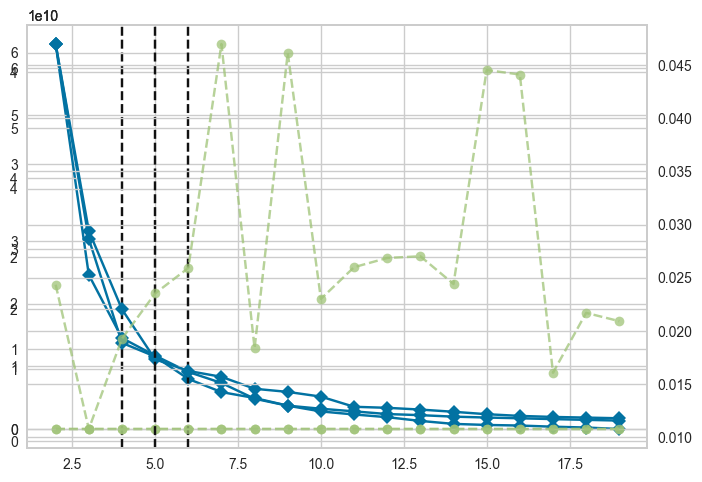

In [11]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import copy

NUMERICAL_FEATURES = [
    "tloc",
    "tmcCabe",
    "assertionDensity",
    "assertionRoulette",
    "mysteryGuest",
    "eagerTest",
    "sensitiveEquality",
    "resourceOptimism",
    "conditionalTestLogic",
    "fireAndForget",
    "testRunWar",
    "loc",
    "lcom2",
    "lcom5",
    "cbo",
    "wmc",
    "rfc",
    "mpc",
    "halsteadVocabulary",
    "halsteadLength",
    "halsteadVolume",
    "classDataShouldBePrivate",
    "complexClass",
    "spaghettiCode",
    "functionalDecomposition",
    "godClass"
]

list_target=[repository1, repository2, repository3]

tmp={
    'repository': [],
    'local_model': [],
    'X_target': [],
    'y_target': [],
}

    
for target in list_target:
    print(target)
    tmp['repository'].append(target)
    
    source_set=dataset.loc[dataset['nameProject']!=target].reset_index(drop=True)
    target_set=dataset.loc[dataset['nameProject']==target].reset_index(drop=True)

    X_target=target_set.drop(['nameProject','testCase','isFlaky'], axis=1)
    y_target=target_set['isFlaky']
    X_source=source_set.drop(['nameProject','testCase','isFlaky'], axis=1)
    y_source=source_set['isFlaky']
    columns=X_source.columns

    tmp['X_target'].append(X_target)
    tmp['y_target'].append(y_target)

    #1. Eseguo il clustering
    km=KMeans(random_state=42, n_init='auto')
    elbow=KElbowVisualizer(km, k=(2,20))
    elbow.fit(X=X_source)
    ideal_cluster=elbow.elbow_value_

    
    print("Numero Cluster generati: {}".format(ideal_cluster))
    km=KMeans(random_state=42, n_clusters=ideal_cluster, n_init='auto')
    km.fit(X=X_source)
    X_source['cluster']=km.predict(X=X_source)

    local_model={
        'Index_Cluster': [],
        'X_cluster': [],
        'y_cluster': [],
        'Local pipeline': []
    }
    
    #pipeline
    pipeline = Pipeline(steps = [('scaler',MinMaxScaler()),
                                 ("model", RandomForestClassifier(class_weight='balanced', random_state=42))]).set_output(transform = "pandas")

    #2. Per ogni cluster addestro un modello
    for i in range(0,ideal_cluster):
        cluster=X_source.loc[X_source['cluster']==i]
        indices=X_source.index[X_source['cluster'] == i].tolist()
        
        local_pip=copy.copy(pipeline)
        local_pip.fit(cluster[NUMERICAL_FEATURES],y_source.iloc[indices])
        y_predict=local_pip.predict(cluster[NUMERICAL_FEATURES])
        #eval_and_log_metrics('Train',y_source.iloc[indices],y_predict)

        local_model['Index_Cluster'].append(i)
        local_model['X_cluster'].append(cluster[NUMERICAL_FEATURES])
        local_model['y_cluster'].append(y_source.iloc[indices])
        local_model['Local pipeline'].append(copy.copy(local_pip))
    
    tmp['local_model'].append(local_model)

    #3. Per ogni campione identifico il cluster d'appartenenza e eseguo la prediction
    y_predict=[]
    for i in range(len(X_target)):
        row=X_target.iloc[i, ].to_numpy()
        row=row.reshape(1,-1)
        index_cluster=km.predict(X=row)
        local_pip=local_model['Local pipeline'][int(index_cluster)]
        y_predict.append(local_pip.predict(row))
    
    
    val_and_log_metrics(y_target,y_predict)




In [13]:
for i in range(0,len(tmp['repository'])):
    print(tmp['repository'][i])
    
    local_model=tmp['local_model'][i]
    
    for index in local_model['Index_Cluster']:
        y_cluster=local_model['y_cluster'][index]
        cluster_TF=np.count_nonzero(y_cluster.to_numpy())
        cluster_TNF=y_cluster.to_numpy().size-cluster_TF
        
        print("Cluster {}: TF {} - TNF {}".format(index,cluster_TF,cluster_TNF))

        


hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb
Cluster 0: TF 82 - TNF 1805
Cluster 1: TF 18 - TNF 133
Cluster 2: TF 264 - TNF 6395
Cluster 3: TF 81 - TNF 346
activiti_b11f757a
Cluster 0: TF 128 - TNF 711
Cluster 1: TF 245 - TNF 5196
Cluster 2: TF 18 - TNF 133
Cluster 3: TF 3 - TNF 39
Cluster 4: TF 27 - TNF 20
Cluster 5: TF 122 - TNF 1968
hector_29e88d0b988d9e5c8dc3b529414a270805ce0d7c
Cluster 0: TF 286 - TNF 6359
Cluster 1: TF 30 - TNF 59
Cluster 2: TF 18 - TNF 133
Cluster 3: TF 111 - TNF 459
Cluster 4: TF 81 - TNF 1826


## 4. CrossProject - LocalModel (Repositroy)

## 5. CrossProject With FeatureSelection

In [31]:
from sklearn.pipeline import Pipeline

import numpy as np
np.random.seed(seed=42)
random.seed(42)

class FeatureSelection_GA:
    
    def __init__(self,source,target,features):
        self.source=source
        self.target=target
        self.features=features
    
    def run(self, size_population, n_iteration, goal, verbose=1):
        self.verbose=verbose
        
        num_instance_selected=int(size_population/3)+int(size_population%3)
        num_instance_crossover=int(size_population/3)
        num_instance_mutation=int(size_population/3)
        
        population=self._gen_initialPopulation(size_population)
        
        fitness_value=[]
        best_fitness=0
        best_ga_instance=None
        
        #Valuto ogni istanza nella popolazione
        best_fitness, best_ga_instance, fitness_value = self._evaluated_population(population)
        
        
        iteration=0
        while iteration<n_iteration and best_fitness<goal:
            # Seleziono K individui
            if self.verbose==1: print("Selezione")
            new_population = self._selection(population, fitness_value, num_instance_selected)
            
            # Eseguo il crossover 
            if self.verbose==1: print("Crossover")
            while len(new_population)<num_instance_selected+num_instance_crossover:
                index_instance1=np.random.randint(low=0, high=num_instance_selected)
                index_instance2=np.random.randint(low=0, high=num_instance_selected)
                new_population.append(self._crossover(new_population[index_instance1],
                                                      new_population[index_instance2]))
            # Mutazione
            if self.verbose==1: print("Mutazione")
            for _ in range(num_instance_mutation):
                index=np.random.randint(low=0, high=num_instance_selected+num_instance_crossover) #Indice Istanza
                new_population.append(self._mutation(new_population[index]))
               
            # Valuto ogni istanza nella popolazione
            population=new_population
            best_fitness, best_ga_instance, fitness_value = self._evaluated_population(population)
            #Inserire qui l'interruzione basata su popolazione migliore
            
            iteration=iteration+1
        
        best_features=[]
        for x, i in zip(best_ga_instance,range(0,len(best_ga_instance))):
            if x==1:
                best_features.append(self.features[i])
                
        return best_features, best_fitness
            
        
        
        
    def fitness_function(self,instance):
        
        featuresToRemove=[]
        for x,i in zip(instance,range(0,len(instance))):
            if x==0: featuresToRemove.append(self.features[i])
        
        if len(featuresToRemove)==len(self.features): return 0
        
        X_target=self.target.drop(['nameProject','testCase','isFlaky']+featuresToRemove, axis=1)
        y_target=self.target['isFlaky']
        X_source=self.source.drop(['nameProject','testCase','isFlaky']+featuresToRemove, axis=1)
        y_source=self.source['isFlaky']
        
        pipeline = Pipeline(steps = [('scaler',MinMaxScaler()),
                                     ("model", RandomForestClassifier(class_weight='balanced', random_state=42))]).set_output(transform = "pandas")

        pipeline.fit(X_source, y_source)
        y_predict=pipeline.predict(X_target)
        acc, pr, rec, f1, tn, fp, fn, tp = val_and_log_metrics(y_target,y_predict,False)
        return f1
        
        
    def _selection(self,population, fitness_values, size):
        
        total_fitness = sum(fitness_values)
        normalized_fitness = [fitness / total_fitness for fitness in fitness_values]

        cumulative_probabilities = [sum(normalized_fitness[:i+1]) for i in range(len(normalized_fitness))]

        selected_individual = []
        best=population[fitness_values.index(max(fitness_values))]
        selected_individual.append(best)
        
        while len(selected_individual)<size:
            random_value = random.random()
            for i, cumulative_probability in enumerate(cumulative_probabilities):
                if random_value <= cumulative_probability:
                    selected_individual.append(population[i])
                    break

        return selected_individual
        
    
    
    def _crossover(self,instance1,instance2):
                       
        split_point = np.random.randint(low=1, high=25)
        new_instance = instance1[0:split_point]+instance2[split_point:]
        #print(len(new_instance))
        return new_instance
    
    
    def _mutation(self, instance):
         #Indice gene 
        new_instance=copy.copy(instance)
        for _ in range(0,3):
            index_gene=np.random.randint(low=0, high=len(instance)) #Indice Instanza
            if new_instance[index_gene]==0: new_instance[index_gene]=1
            else: new_instance[index_gene]=0
        return new_instance
                       
    def _gen_initialPopulation(self,size_population):
        
        population=[]
        for i in range(size_population):
            n = np.random.randint(low=1, high=27)  # Sostituisci 11 con il numero desiderato di 1
            m = 26 - n
            # Crea un array con n elementi 1 e m elementi 0 ordinati in modo casuale
            array_casuale = np.array([1] * n + [0] * m)
            np.random.shuffle(array_casuale)
            population.append(array_casuale.tolist())
        
        return population

    def _evaluated_population(self,population):
        
        fitness_value=[]
        best_fitness=0
        
        best_ga_instance=None
        for instance,i in zip(population, range(0,len(population))):
            fit=self.fitness_function(instance) 
            fitness_value.append(fit)
            if self.verbose==1: print('{}. {} : {}'.format(i,instance,fit))
            if fit>best_fitness:
                best_fitness=fit
                best_ga_instance=instance
        
        return best_fitness, best_ga_instance, fitness_value
        

In [35]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



list_target=[repository1, repository2, repository3]

NUMERICAL_FEATURES = [
    "tloc",
    "tmcCabe",
    "assertionDensity",
    "assertionRoulette",
    "mysteryGuest",
    "eagerTest",
    "sensitiveEquality",
    "resourceOptimism",
    "conditionalTestLogic",
    "fireAndForget",
    "testRunWar",
    "loc",
    "lcom2",
    "lcom5",
    "cbo",
    "wmc",
    "rfc",
    "mpc",
    "halsteadVocabulary",
    "halsteadLength",
    "halsteadVolume",
    "classDataShouldBePrivate",
    "complexClass",
    "spaghettiCode",
    "functionalDecomposition",
    "godClass"
]


for target in list_target:
    print('Repository: {}'.format(target))
    
    target_set=dataset.loc[dataset['nameProject']==target]
    source_set=dataset.loc[dataset['nameProject']!=target]
    
    geneticAlghoritm=FeatureSelection_GA(source_set, target_set,NUMERICAL_FEATURES)
    best_ga_instance, best_fitness=geneticAlghoritm.run(100,30,0.7,0)
    
    print("Best Solution")
    print('{} : {}'.format(best_ga_instance, best_fitness))
    
    
    X_target=target_set[best_ga_instance]
    y_target=target_set['isFlaky']
    X_source=source_set[best_ga_instance]
    y_source=source_set['isFlaky']
    

    X_source_train, X_source_test, y_source_train, y_source_test= train_test_split(X_source, y_source,stratify=y_source, test_size=0.20,random_state=42)
    
    
    pipeline = Pipeline(steps = [('scaler',MinMaxScaler()),
                                 ("model", RandomForestClassifier(criterion='gini',
                                                                  n_estimators=150,
                                                                  class_weight='balanced', random_state=42))])

    pipeline.fit(X_source_train,y_source_train)
    y_predict=pipeline.predict(X_source_train)
    eval_and_log_metrics('Train',y_source_train,y_predict)
    print('     Performance Test')
    y_predict=pipeline.predict(X_source_test)
    val_and_log_metrics(y_source_test,y_predict)
    print('     Performance Target')
    y_predict=pipeline.predict(X_target)
    val_and_log_metrics(y_target,y_predict)
    print('')
    
   
    

   
    


Repository: hbase_e593f0efbf1144bcb5909d2630321e631a2e66bb
Best Solution
['conditionalTestLogic', 'testRunWar', 'lcom5', 'functionalDecomposition'] : 0.5
    |--- Train_ACC 0.5958350458966982
    |--- Train_PR 0.08402822322001283
    |--- Train_REC 0.7359550561797753
    |--- Train_F1 0.15083477259643063
     Performance Test


TypeError: 'bool' object is not callable

# MIC_SM_FS

In [56]:
import minepy

for target in list_target[0:1]:
    print('Repository: {}'.format(target))
    
    target_set=dataset.loc[dataset['nameProject']==target]
    sources_set=dataset.loc[dataset['nameProject']!=target]
    
    
    X_sources_set=sources_set.drop(['nameProject','testCase','isFlaky'],axis=1)
    y_sources_set=source_set['isFlkay']
    X_target_set=target_set.drop(['nameProject','testCase','isFlaky'],axis=1)
    X_target_set=target_set['isFlkay']
    
    

ImportError: dlopen(/Users/angeloafeltra/anaconda3/envs/Flakiness_ML_Experiments/lib/python3.10/site-packages/minepy/mine.cpython-310-darwin.so, 0x0002): tried: '/Users/angeloafeltra/anaconda3/envs/Flakiness_ML_Experiments/lib/python3.10/site-packages/minepy/mine.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/angeloafeltra/anaconda3/envs/Flakiness_ML_Experiments/lib/python3.10/site-packages/minepy/mine.cpython-310-darwin.so' (no such file), '/Users/angeloafeltra/anaconda3/envs/Flakiness_ML_Experiments/lib/python3.10/site-packages/minepy/mine.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))